<a href="https://colab.research.google.com/github/afifaniks/triagerX/blob/main/notebook/Fine_Tune_Llama_2_with_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Oct 16 00:53:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   33C    P0    53W / 300W |      0MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 torch scipy pandas matplotlib

In [3]:
import os
import re
import torch
from datasets import load_dataset
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    StoppingCriteria, 
    StoppingCriteriaList
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

## Data Exploration

In [4]:
data_path = "data/openj9/openj9_issues.csv"
df = pd.read_csv(data_path)
df = df.drop("Unnamed: 0", axis=1)

df.head()

,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees
0,10,https://github.com/eclipse-openj9/openj9/pull/10,Update README.md with proper AdoptOpenJDK link,"Also remove the the coming soon reference, sin...",closed,pshipton,NaN,charliegracie
1,15,https://github.com/eclipse-openj9/openj9/pull/15,Refactor and clean up CodeCacheManager,- Change invocation parameters of superclass c...,closed,lmaisons,<comment><user>lmaisons</user><body>This has a...,0xdaryl
2,17,https://github.com/eclipse-openj9/openj9/pull/17,WIP Add support for function pointers in Panama,When invoking a native function (with Panama) ...,closed,tajila,<comment><user>tajila</user><body>Thanks for t...,DanHeidinga
3,22,https://github.com/eclipse-openj9/openj9/pull/22,fix illegal-access behaviour,fix illegal-access behaviour\r\n\r\nThis is th...,closed,tajila,<comment><user>DanHeidinga</user><body>@tajila...,DanHeidinga
4,24,https://github.com/eclipse-openj9/openj9/issue...,Enable a travis.ci-based PR build for linux x8...,Build a basic PR build based off the linux_x86...,closed,DanHeidinga,<comment><user>mgaudet</user><body>This has be...,DanHeidinga


In [5]:
df[5000:5005]

,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees
5000,16649,https://github.com/eclipse-openj9/openj9/issue...,Scripts not permitted to use staticMethod org....,https://openj9-jenkins.osuosl.org/job/Test_ope...,closed,pshipton,<comment><user>llxia</user><body>`makeTap13Yam...,AdamBrousseau
5001,16650,https://github.com/eclipse-openj9/openj9/pull/...,Implement JITServer AOT cache thunk handling,These commits add J2I thunk handling to the JI...,closed,cjjdespres,<comment><user>cjjdespres</user><body>Attn @mp...,mpirvu
5002,16652,https://github.com/eclipse-openj9/openj9/issue...,Skynet failures on larger machines,The Skynet test fails readily (maybe 1 in 5 ru...,closed,0xdaryl,<comment><user>0xdaryl</user><body>FYI @fengxu...,LinHu2016
5003,16655,https://github.com/eclipse-openj9/openj9/issue...,jdk20 OpenJDK java/lang/Class/getEnumConstants...,https://openj9-jenkins.osuosl.org/job/Test_ope...,closed,pshipton,NaN,pshipton
5004,16656,https://github.com/eclipse-openj9/openj9/issue...,jdk20 OpenjDK java/lang/Thread/jni/AttachCurre...,https://openj9-jenkins.osuosl.org/job/Test_ope...,closed,pshipton,<comment><user>pshipton</user><body>@tajila fy...,babsingh


In [6]:
total_contributors = len(df["assignees"].unique())
print(f"Total contributors: {total_contributors}")

Total contributors: 127


In [7]:
minimum_contribution = 30

developers = df["assignees"].value_counts()

In [8]:
filtered_developers = developers.index[developers >= minimum_contribution]

In [9]:
filtered_df = df[df["assignees"].isin(filtered_developers)]

<Axes: xlabel='assignees'>

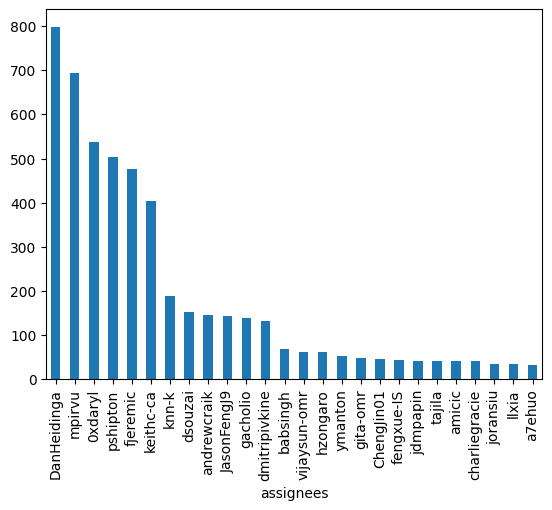

In [10]:
filtered_df["assignees"].value_counts().plot(kind="bar")

## Model Configuration

In [11]:
model_name = "NousResearch/Llama-2-7b-chat-hf"
data_path = "data/openj9/openj9_issues.csv"
new_model = "llama-2-7b-openj9"

# Set QLoRA configuration
lora_r = 64 # Attention dimension/rank
lora_alpha = 16
lora_dropout = 0.05

# Set bitsandbytes configuration
use_4bit = True #For  4-bit precision base model loading
bnb_4bit_compute_dtype = "float16" # Compute dtype for 4-bit base models
bnb_4bit_quant_type = "nf4" # Quantization type (fp4 or nf4)
use_nested_quant = False # Activate nested quantization for 4-bit base models (double quantization)


# Set training params
output_dir = "./results"
num_train_epochs = 1
fp16 = False
bf16 = False
per_device_train_batch_size = 8
per_device_eval_batch_size = 8
gradient_accumulation_steps = 1
gradient_checkpointing = True
max_grad_norm = 0.3
learning_rate = 2e-4
weight_decay = 0.001
optim = "paged_adamw_32bit"
lr_scheduler_type = "cosine"
max_steps = 250
warmup_ratio = 0.03
group_by_length = True # Group sequences into batches with same length saves memory and speeds up training considerably
save_steps = 0
logging_steps = 10

# Set SFT parameters
max_seq_length = None
packing = False # Pack multiple short examples in the same input sequence to increase efficiency
device_map = {"": 0} # Load the entire model on the GPU 0

In [12]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

## Load Base Model

In [13]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Using it for optimized model loading
    device_map=device_map
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix overflow issue with fp16 training

## Prompt Template Generation

In [15]:
# formatted_text = f"<s><INST>Issue Title:\n{data['issue_title'][i]}" \
#     + f"\nIssue Description:\n{data['description'][i]}\nWho can fix this issue?\n</INST>The issue can be fixed by: {data['owner'][i]}</s>"

import xml.etree.ElementTree as ET

def parse_comments(comments: str):
    xml_like =  ET.ElementTree(ET.fromstring(comments))

def generate_prompt_with_answer(entry):
    comments = entry["comments"] # TBD

    issue_title = entry["issue_title"]
    issue_description = entry["issue_body"]
    assignees = entry["assignees"]
    
    prompt = f"""<s><INST>Suggest a developer based on the issue title and description given below. 
If the question cannot be answered using the information provided answer with "I don't know".

Issue Title: {issue_title}

Issue Description: {issue_description}

===========================================================================================
Question: Which developer can fix this issue?

Answer: </INST>{assignees}</s>
"""

    return prompt

def generate_prompt_without_answer(entry):
    issue_title = entry["issue_title"]
    issue_description = entry["issue_body"]
    
    prompt = f"""<s><INST>Suggest a developer based on the issue title and description given below. 
If the question cannot be answered using the information provided answer with "I don't know".

Issue Title: {issue_title}

Issue Description: {issue_description}

===========================================================================================
Question: Which developer can fix this issue?

Answer: </INST></s>
"""

    return prompt



In [16]:
print(generate_prompt_with_answer(filtered_df.iloc[4777]))

<s><INST>Suggest a developer based on the issue title and description given below. 
If the question cannot be answered using the information provided answer with "I don't know".

Issue Title: Hoist getSupportsInlineStringHashCode check for better readability

Issue Description: nan

Question: Which developer can fix this issue?

Answer: </INST>0xdaryl</s>



## Test Base Model

In [17]:
device = f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu'
stop_list = ['\nHuman:', '\n```\n']

stop_token_ids = [tokenizer(x)['input_ids'] for x in stop_list]
stop_token_ids = [torch.LongTensor(x).to(device) for x in stop_token_ids]

class StopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for stop_ids in stop_token_ids:
            if torch.eq(input_ids[0][-len(stop_ids):], stop_ids).all():
                return True
        return False

stopping_criteria = StoppingCriteriaList([StopOnTokens()])

In [18]:
def inference(model, tokenizer, prompt, max_length=20):
  pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=max_length, stopping_criteria=stopping_criteria)
  result = pipe(f"<s>[INST] {prompt} [/INST]")

  return result[0]["generated_text"]

In [19]:
print(inference(model, tokenizer, generate_prompt_without_answer(filtered_df.iloc[1200])))

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
Input length of input_ids is 182, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


<s>[INST] <s><INST>Suggest a developer based on the issue title and description given below. 
If the question cannot be answered using the information provided answer with "I don't know".

Issue Title: AArch64: Enable build of JIT shared library

Issue Description: This commit enables the build of JIT shared library for aarch64.
The library can be linked, while it cannot be loaded by the VM at
this point because of undefined symbols.

Closes: #4854

Signed-off-by: knn-k <konno@jp.ibm.com>

Question: Which developer can fix this issue?

Answer: </INST></s>
 [/INST] 


## Setup Training Pipeline

In [20]:
dataset = load_dataset("csv", data_files=data_path, split="train")

In [21]:
def format_dataset(data):
    output_texts = []
    
    for i in range(len(data["issue_number"])):
        formatted_text = generate_prompt_with_answer(data)
        output_texts.append(formatted_text)

    return output_texts

In [22]:
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)
    else:
      print(f"Using {compute_dtype}")

Your GPU supports bfloat16: accelerate training with bf16=True


In [23]:
model.config.use_cache = False
model.config.pretraining_tp = 1

peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)

training_params = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_params,
    packing=packing,
    formatting_func=format_dataset
)

trainer.train()
trainer.model.save_pretrained(new_model)

/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/5360 [00:00<?, ? examples/s]

## Memory Cleanup to Save Fine-Tuned Model (Google Colab)

In [ ]:
# del model
# del trainer
# import gc
# gc.collect()
# gc.collect()

## Merge LoRA Weights with Base Model

In [ ]:
model_name, new_model

('NousResearch/Llama-2-7b-chat-hf', 'llama-2-7b-deeptriage')

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
issue_title = "NaCl 3D busted - command buffer initialization failure"
issue_description = "What steps will reproduce the problem?1. Start Chrome2. Attempt to run a Native Client 3D module (e.g. angrybots)3. ""Aw, snap"". Note line ""Failed to create context"" in log below.I have only tested this on MacOS. Two most recent canary builds (16.0.909, 16.0.910) fail, as well as head of tree. I have a browser build @105335 (13 Oct) and it works fine, so it appears to be a change between 105335 and whatever the rev for Canary 16.0.909 would be.dhcp-172-19-0-123:src bradchen$ /Applications/Google\ Chrome\ Canary.app/Contents/MacOS/Google\ Chrome\ Canary  --enable-nacl[34896:2307:20612385773456:ERROR:process_util_mac.mm(283)] Invalid process[34907,2954604544:04:52:38.029878] NaCl_page_alloc_randomized: 0xde7a2a0b[34907,2954604544:04:52:38.030035] NaCl_page_alloc_randomized: hint 0x5e7a0000[34907,2954604544:04:52:38.030136] NaClMakePcrelThunk: got addr 0x5e7a0000[34903,2953392128:04:52:38.099973] PluginReverseInterface::StartupInitializationComplete[34903,2953392128:04:52:38.100020] PluginReverseInterface::StartupInitializationComplete: invoking CBUnityModule.[34909:263:20627425695745:ERROR:gpu_command_buffer_stub.cc(225)] Failed to create context.[34903:263:20627425900735:ERROR:command_buffer_proxy.cc(136)] Failed to initialize command buffer service.[SRPC:NACL:34907,1056900288:11:52:38.539000] NaClSrpcRpcWait(channel=0x3efc0bb0): EOF is received instead of response. Probably, the other side (usually, nacl module or browser plugin) crashed. "
print(inference(model, tokenizer, f"Issue Title: {issue_title}\nIssue Description: {issue_description} Who can this issue", 3000))

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s>[INST] Issue Title: NaCl 3D busted - command buffer initialization failure
Issue Description: What steps will reproduce the problem?1. Start Chrome2. Attempt to run a Native Client 3D module (e.g. angrybots)3. Aw, snap. Note line Failed to create context in log below.I have only tested this on MacOS. Two most recent canary builds (16.0.909, 16.0.910) fail, as well as head of tree. I have a browser build @105335 (13 Oct) and it works fine, so it appears to be a change between 105335 and whatever the rev for Canary 16.0.909 would be.dhcp-172-19-0-123:src bradchen$ /Applications/Google\ Chrome\ Canary.app/Contents/MacOS/Google\ Chrome\ Canary  --enable-nacl[34896:2307:20612385773456:ERROR:process_util_mac.mm(283)] Invalid process[34907,2954604544:04:52:38.029878] NaCl_page_alloc_randomized: 0xde7a2a0b[34907,2954604544:04:52:38.030035] NaCl_page_alloc_randomized: hint 0x5e7a0000[34907,2954604544:04:52:38.030136] NaClMakePcrelThunk: got addr 0x5e7a0000[34903,2953392128:04:52:38.099973] P

In [ ]:
print(inference(model, tokenizer, "Issue Title: All default search engine settings were wiped out\nIssue Description: The DhcpProxyScriptFetcher implementation (net/proxy/dhcp_proxy_script_fetcher_win.cc and net/proxy/dhcp_proxy_script_adapter_fetcher_win.cc) currently uses base::WorkerPool, which we plan to deprecate (see issue 251774).It would also make a lot of sense to use only a limited number of threads to fetch DHCP PAC information.Therefore, this bug tracks switching this implementation to use base::SequencedWorkerPool with a limit of 10 threads, that is owned by the DhcpProxyScriptFetcher and handed to each DhcpProxyScriptAdapterFetcher.  An equivalent to the current base::WorkerPool::PostTaskAndReply should be to PostTaskAndReply on a TaskRunner retrieved using SequencedWorkerPool::GetTaskRunnerWithShutdownBehavior(CONTINUE_ON_SHUTDOWN).This should be relatively straightforward and I have a possible volunteer in mind, so I'm tagging it as a GoodFirstBug.\nWho can fix this issue?", 1500))

<s>[INST] Issue Title: All default search engine settings were wiped out
Issue Description: The DhcpProxyScriptFetcher implementation (net/proxy/dhcp_proxy_script_fetcher_win.cc and net/proxy/dhcp_proxy_script_adapter_fetcher_win.cc) currently uses base::WorkerPool, which we plan to deprecate (see issue 251774).It would also make a lot of sense to use only a limited number of threads to fetch DHCP PAC information.Therefore, this bug tracks switching this implementation to use base::SequencedWorkerPool with a limit of 10 threads, that is owned by the DhcpProxyScriptFetcher and handed to each DhcpProxyScriptAdapterFetcher.  An equivalent to the current base::WorkerPool::PostTaskAndReply should be to PostTaskAndReply on a TaskRunner retrieved using SequencedWorkerPool::GetTaskRunnerWithShutdownBehavior(CONTINUE_ON_SHUTDOWN).This should be relatively straightforward and I have a possible volunteer in mind, so I'm tagging it as a GoodFirstBug.
Who can fix this issue? [/INST]  The issue can 

In [ ]:
print(inference(model, tokenizer, "Issue Title: tpmc needs to produce a better error message when it fails to open the TPM device\nIssue Description: Currently the open fails quietly, then tpmc fails at sending a command and the error message is horrible (forgot to call TlclLibInit()?)\nWho can fix this issue?", 400))

<s>[INST] Issue Title: tpmc needs to produce a better error message when it fails to open the TPM device
Issue Description: Currently the open fails quietly, then tpmc fails at sending a command and the error message is horrible (forgot to call TlclLibInit()?)
Who can fix this issue? [/INST]  The issue can be fixed by: james.k.brown@chromium.org.


In [ ]:
print(inference(model, tokenizer, "Issue Title: Scrolling Issue\nIssue Description: Scroll down works but scroll up did not work.\nWho can fix this issue?", 1500))

<s>[INST] Issue Title: Scrolling Issue
Issue Description: Scroll down works but scroll up did not work.
Who can fix this issue? [/INST]  The issue can be fixed by: kyotaro@chromium.org 


In [ ]:
print(inference(model, tokenizer, "Issue Title: Resolution change videos are not playing\nIssue Description: Could not play video if the resolution changes during playback.\nWho can fix this issue?", 1500))

<s>[INST] Issue Title: Resolution change videos are not playing
Issue Description: Could not play video if the resolution changes during playback.
Who can fix this issue? [/INST]  The issue can be fixed by: james@chromium.org 


In [ ]:
!huggingface-cli login

model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

## Test Fine-Tuned Model

In [ ]:
# try:
#     del tokenizer
#     del model
#     del base_model
# except:
#     pass

In [ ]:
hf_custom_model_path = f"afifaniks/{new_model}"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)

In [ ]:
model = PeftModel.from_pretrained(model, hf_custom_model_path)
model = model.merge_and_unload()

In [ ]:
print(inference(model, tokenizer, "Why birds don't have wheels?"))

In [ ]:
print(inference(model, tokenizer, "Can you write some Delphi code that uses named pipes?"))

In [ ]:
print(inference(model, tokenizer, "Which is a species of fish? Tope or Rope"))